## Introduction
Simple notebook where we show off some pytorch functionality by:
1) Calculating and plotting the gradient of the sigmoid function.
2) Training a neural net to solve a regression problem.

In [1]:
#import packages
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Gradient of Function

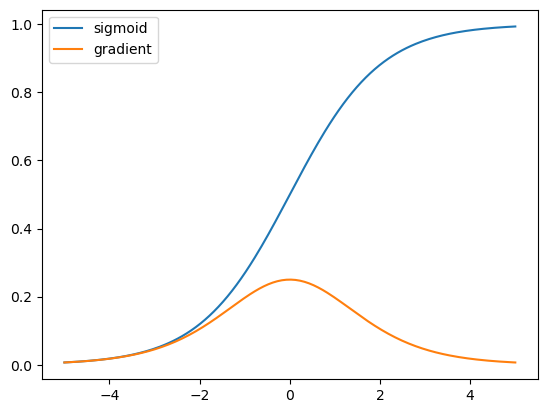

In [2]:
# example calculating and plotting a function's gradient
x = torch.linspace(-5,5,steps=200, requires_grad=True) # require gradient on input
y = torch.sigmoid(x)
y.sum().backward() # we differentiate with respect to the sum
plt.plot(x.detach(), y.detach(), label='sigmoid') #detach gradient before plotting
plt.plot(x.detach(), x.grad, label='gradient')
plt.legend()
plt.show()

## Neural Network regression example

Simple example where we:

1) Generate a regression dataset
2) Define a simple regression NN
3) Fit the NN to the train set and test the results on the test set.

In [3]:
# create a simple regression dataset
from sklearn.datasets import make_regression
X, y = make_regression(n_samples=2_000, random_state=0)

Plot to show makeup of data. Predictors have 0 mean and std of 1, most predictors are correlated with target.
Notice that the predictors appear to be standard normal, but the target is of a much larger magnitide (left histogram). We will need to normalize the target to allow for this.

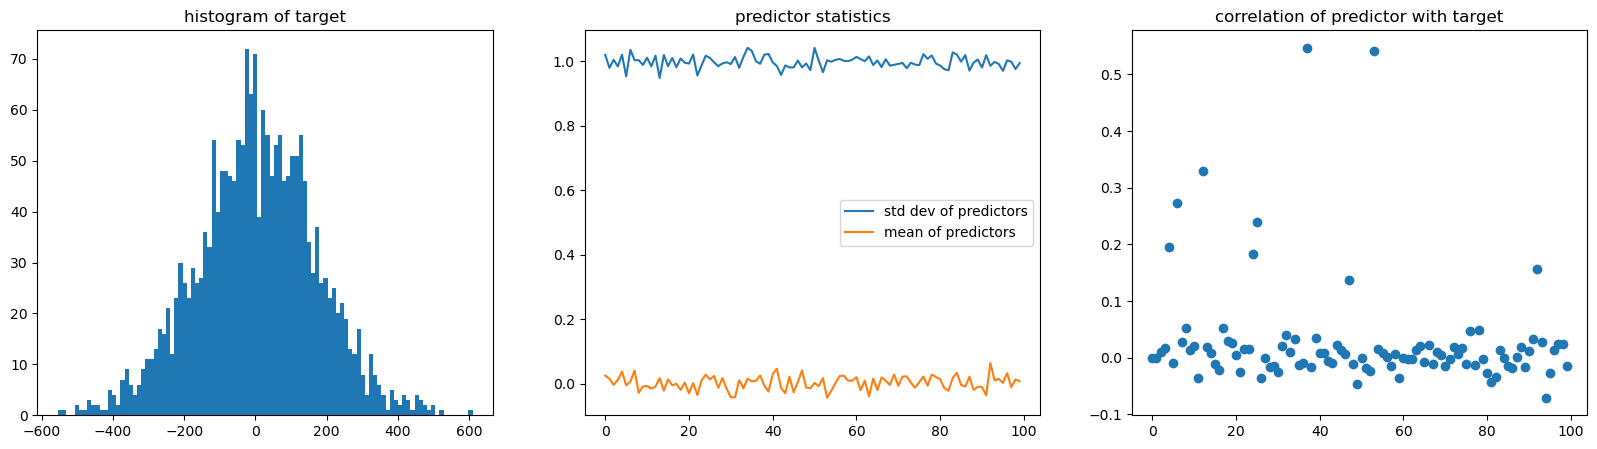

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20,5))
ax1.hist(y, bins = 100)
ax1.set_title('histogram of target')
ax2.plot(X.std(axis=0), label = 'std dev of predictors')
ax2.plot(X.mean(axis=0), label = 'mean of predictors')
ax2.legend()
ax2.set_title('predictor statistics')
ax3.scatter(x = range(100), y = [np.corrcoef(X[:,i],y)[1,0] for i in range(100)])
ax3.set_title('correlation of predictor with target')
plt.show()

In [5]:
# define our simple neural network. RELU is used to introduce non-linearity between layers.
class RegressionNN(nn.Module):
    def __init__(self):
        super(RegressionNN, self).__init__()
        self.l1 = nn.Linear(100, 20)
        self.l2 = nn.Linear(20, 20)
        self.l3 = nn.Linear(20, 1)
    
    def forward(self, x):
        x = torch.relu(self.l1(x))
        x = torch.relu(self.l2(x))
        x = self.l3(x)
        return(x)

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(torch.tensor(X).float(), torch.tensor(y).float().reshape(-1,1))

# define a normalization function and it's inverse for y, we could alternatively use scikit learn std scalar
# this is necessay because y is of a much larger magnitude that the predictors (see above plots)
y_std, y_mean = y_train.std(), y_train.mean()
def norm_y(y):
    return (y-y_mean)/y_std
def inverse_norm_y(y):
    return y*y_std + y_mean

epoch 50, train loss:0.883049, test_loss: 0.882206
epoch 100, train loss:0.371967, test_loss: 0.415240
epoch 150, train loss:0.081916, test_loss: 0.109100
epoch 200, train loss:0.046294, test_loss: 0.073913
epoch 250, train loss:0.032444, test_loss: 0.059588


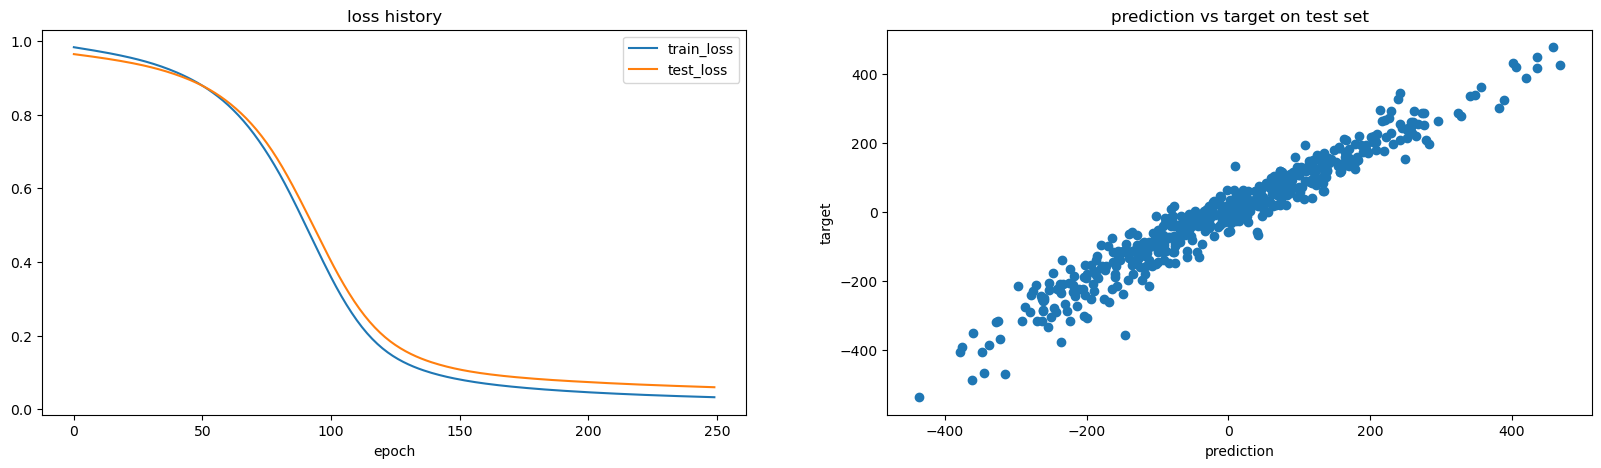

In [7]:
# define our variables
model = RegressionNN()
criterion = nn.MSELoss()
trainer = torch.optim.SGD(model.parameters(), lr=0.03)
epochs = 250
loss_hist = dict(train=[], test=[])

#training loop:
for i in range(epochs):
    # train and optimize:
    trainer.zero_grad()
    pred = model(X_train)
    loss = criterion(pred, norm_y(y_train))
    loss.backward()
    trainer.step()
    
    #test evaluation:
    with torch.no_grad():
        pred = model(X_test)
        test_loss = criterion(pred, norm_y(y_test))
    
    #debug output:
    if (i+1)%50 == 0:
        print(f'epoch {i+1}, train loss:{loss.detach():3f}, test_loss: {test_loss.detach():3f}')
        
    # save output for plot
    loss_hist['train']+= [loss.detach().numpy()]
    loss_hist['test']+= [test_loss.detach().numpy()]

#plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,5))
ax1.plot(loss_hist['train'], label = 'train_loss')
ax1.plot(loss_hist['test'], label = 'test_loss')
ax1.set_title('loss history')
ax1.legend()
ax1.set_xlabel('epoch')
ax2.scatter(inverse_norm_y(model(X_test).detach()), (y_test))
ax2.set_xlabel('prediction'); ax2.set_ylabel('target')
ax2.set_title('prediction vs target on test set')
plt.show()

Notice that the test and train loss have stopped decreasing (first plot) and that the model predictions are strongly correlated with the target values (second plot). This indicates that the neural net now provides a good model for the data.